In [1]:
cd

/Users/keithwalcott


In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import statsmodels.api as sm
from itertools import combinations
import plotly.graph_objs as go
import plotly.express as px
from ipywidgets import widgets

In [3]:
codon_variant = pd.read_csv('kw_dms/results/variants/codon_variants.csv', usecols=['barcode','library','barcode','codon_substitutions','aa_substitutions','n_codon_substitutions','n_aa_substitutions'])

def calculate_functional_score(pre_selection, pre_selection_name, post_selection, post_selection_name, library, count_threshold):
    # Rename count columns
    pre_selection.rename(columns={'count': 'count_pre'}, inplace=True)
    post_selection.rename(columns={'count': 'count_post'}, inplace=True)
    
    pre_selection = pre_selection[(pre_selection['count_pre'] >= count_threshold)] 
    
    # Merge codon_variants with 
    pre_selection = pd.merge(pre_selection, codon_variant, on='barcode')
    post_selection = pd.merge(post_selection, codon_variant, on='barcode')
    
    #filter out barcodes not in intended library
    pre_selection = pre_selection[pre_selection['library'] == library]
    post_selection = post_selection[post_selection['library'] == library]
    
    # Merge pre and post counts
    merged_df = pd.merge(pre_selection, post_selection[['barcode', 'count_post']], on='barcode', how='left')
    merged_df.fillna(0, inplace=True)

    # Change zeroes in 'count_post' to 0.5
    # Convert 'count_post' column to float
    merged_df['count_post'] = merged_df['count_post'].astype(float)

    # Now change zeroes in 'count_post' to 0.5
    merged_df.loc[merged_df['count_post'] == 0, 'count_post'] = 0.5
    
    # Calculate total wt counts then filter them out of the df
    wt_barcodes = merged_df[merged_df['n_codon_substitutions'] == 0]
    pre_wt_counts = wt_barcodes['count_pre'].sum()
    post_wt_counts = wt_barcodes['count_post'].sum()
    merged_df = merged_df[merged_df['n_codon_substitutions'] > 0]
    
    # Calculate the functional score for each row
    merged_df['func_score'] = np.log2((merged_df['count_post'] / post_wt_counts) / (merged_df['count_pre'] / pre_wt_counts))
 
    # Extract the specific parts of the names for renaming
    pre_suffix = pre_selection_name.split('_')[1] if '_' in pre_selection_name else 'pre'
    post_suffix = post_selection_name.split('_')[1] if '_' in post_selection_name else 'post'

    # Rename count columns
    merged_df.rename(columns={'count_pre': f'{pre_selection_name}_count'}, inplace=True)
    merged_df.rename(columns={'count_post': f'{post_selection_name}_count'}, inplace=True)

    return merged_df

In [4]:
def merge_dataframes(dataframes_dict):
    merged_group_dict = {}

    # Create combinations of the keys (and their corresponding dataframes)
    for (key1, df1), (key2, df2) in combinations(dataframes_dict.items(), 2):
        # Rename 'func_score' and 'func_score_var' columns in df1 and df2
        df1_renamed = df1.rename(columns={
            'func_score': f'{key1}_func_score',
            'func_score_var': f'{key1}_func_score_var'
        })
        df2_renamed = df2.rename(columns={
            'func_score': f'{key2}_func_score',
            'func_score_var': f'{key2}_func_score_var'
        })

        # Merge DataFrames pairwise
        merged_df = pd.merge(df1_renamed, df2_renamed, on=['barcode', 'library', 'aa_substitutions', 'n_aa_substitutions','codon_substitutions', 'n_codon_substitutions'], how='outer')

        # Drop rows with NaNs in either of the func_score columns
        func_score_cols = [col for col in merged_df.columns if '_func_score' in col]
        merged_df.dropna(subset=func_score_cols, inplace=True)

        # Process duplicate '_count' columns
        count_columns_x = [col for col in merged_df.columns if col.endswith('_x') and '_count' in col]
        count_columns_y = [col for col in merged_df.columns if col.endswith('_y') and '_count' in col]

        for col_x, col_y in zip(count_columns_x, count_columns_y):
            base_col = col_x.replace('_x', '')
            merged_df[base_col] = merged_df[col_x].fillna(merged_df[col_y])
            merged_df.drop(columns=[col_x, col_y], inplace=True)

        # Store the merged DataFrame
        merged_group_dict[f'{key1}-and-{key2}'] = merged_df

    return merged_group_dict


In [55]:
sample_DMSO_B1T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-DMSO_bio1-1_counts.csv')
sample_DMSO_B1T2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-DMSO_bio1-2_counts.csv')
sample_DMSO_B2T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-DMSO_bio2-1_counts.csv')
sample_DMSO_B2T2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-DMSO_bio2-2_counts.csv')

sample_4u8c_B1T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-4u8c_bio1-1_counts.csv')
sample_4u8c_B2T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-4u8c_bio2-1_counts.csv')
sample_4u8c_B2T2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-4u8c_bio2-2_counts.csv')

sample_C7_B1T2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-C7_bio1-2_counts.csv')
sample_C7_B2T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-C7_bio2-1_counts.csv')

sample_Both_B1T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Both_bio1-1_counts.csv')
sample_Both_B2T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Both_bio2-1_counts.csv')

func_scores_KW = {}
func_scores_KW['4u8c_B1T1-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_4u8c_B1T1,'4u8c_B1T1','LibB',25)
func_scores_KW['4u8c_B2T1-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_4u8c_B2T1,'4u8c_B2T1','LibB',25)
func_scores_KW['4u8c_B2T2-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_4u8c_B2T2,'4u8c_B2T2','LibB',25)
func_scores_KW['4u8c_B2T2-vs-DMSO_B2T2']=calculate_functional_score(sample_DMSO_B2T2,'DMSO_B2T2',sample_4u8c_B2T2,'4u8c_B2T2','LibB',25)

func_scores_KW['C7_B1T2-vs-DMSO_B1T2']=calculate_functional_score(sample_DMSO_B1T2,'DMSO_B1T2',sample_C7_B1T2,'C7_B1T2','LibB',25)
func_scores_KW['C7_B2T1-vs-DMSO_B2T1']=calculate_functional_score(sample_DMSO_B2T1,'DMSO_B2T1',sample_C7_B2T1,'C7_B2T1','LibB',25)

func_scores_KW['Both_B1T1-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_Both_B1T1,'Both_B1T1','LibB',25)
func_scores_KW['Both_B2T1-vs-DMSO_B2T1']=calculate_functional_score(sample_DMSO_B2T1,'DMSO_B2T1',sample_Both_B2T1,'Both_B2T1','LibB',25)

func_score_comparisons_KW = merge_dataframes(func_scores_KW)

In [73]:
sample_1X_B1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Spike_DMSO_bio1_1X-1_counts.csv')
sample_5X_B1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Spike_DMSO_bio1_5X-1_counts.csv')
sample_10X_B1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Spike_DMSO_bio1_10X-1_counts.csv')

sample_1X_B2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Spike_DMSO_bio2_1X-1_counts.csv')
sample_5X_B2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Spike_DMSO_bio2_5X-1_counts.csv')
sample_10X_B2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Spike_DMSO_bio2_10X-1_counts.csv')

func_scores_coverage = {}
func_scores_coverage['1X_B1-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_1X_B1,'1X_B1','LibB',25)
func_scores_coverage['5X_B1-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_5X_B1,'5X_B1','LibB',25)
func_scores_coverage['10X_B1-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_10X_B1,'10X_B1','LibB',25)


func_score_comparisons_coverage = merge_dataframes(func_scores_coverage)

In [31]:
sample_noAB_B1 = pd.read_csv('/Users/keithwalcott/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_no-antibody_control_1.csv', usecols=['barcode','count'])
sample_noAB_B2 = pd.read_csv('/Users/keithwalcott/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_no-antibody_control_2.csv', usecols=['barcode','count'])
sample_LyCoV10_B1 = pd.read_csv('/Users/keithwalcott/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_antibody_LyCoV-1404_10.464_1.csv', usecols=['barcode','count'])
sample_LyCoV10_B2 = pd.read_csv('/Users/keithwalcott/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_antibody_LyCoV-1404_10.464_2.csv', usecols=['barcode','count']) 
sample_LyCoV06_B1 = pd.read_csv('/Users/keithwalcott/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_antibody_LyCoV-1404_0.654_1.csv', usecols=['barcode','count'])
sample_LyCoV06_B2 = pd.read_csv('/Users/keithwalcott/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_antibody_LyCoV-1404_0.654_2.csv', usecols=['barcode','count']) 
sample_LyCoV2_B1 = pd.read_csv('/Users/keithwalcott/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_antibody_LyCoV-1404_2.616_1.csv', usecols=['barcode','count'])
sample_LyCoV2_B2 = pd.read_csv('/Users/keithwalcott/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_antibody_LyCoV-1404_2.616_2.csv', usecols=['barcode','count']) 

func_scores_BD = {}

func_scores_BD['LyCoV10_B1-vs-noAB_B1'] = calculate_functional_score(sample_noAB_B1,'DMSO_B1',sample_LyCoV10_B1,'LyCoV10_B1','LibA',25)
func_scores_BD['LyCoV10_B2-vs-noAB_B2'] = calculate_functional_score(sample_noAB_B2,'DMSO_B2',sample_LyCoV10_B2,'LyCoV10_B2','LibA',25)
func_scores_BD['LyCoV06_B1-vs-noAB_B1'] = calculate_functional_score(sample_noAB_B1,'DMSO_B1',sample_LyCoV06_B1,'LyCoV06_B1','LibA',25)
func_scores_BD['LyCoV06_B2-vs-noAB_B2'] = calculate_functional_score(sample_noAB_B2,'DMSO_B2',sample_LyCoV06_B2,'LyCoV06_B2','LibA',25)
func_scores_BD['LyCoV2_B1-vs-noAB_B1'] = calculate_functional_score(sample_noAB_B1,'DMSO_B1',sample_LyCoV2_B1,'LyCoV2_B1','LibA',25)
func_scores_BD['LyCoV2_B2-vs-noAB_B2'] = calculate_functional_score(sample_noAB_B2,'DMSO_B2',sample_LyCoV2_B2,'LyCoV2_B2','LibA',25)


func_score_comparisons_BD = merge_dataframes(func_scores_BD)

In [14]:
def calculate_n_selections(df, threshold):
    # Filter for non-DMSO count columns
    non_dmso_count_cols = [col for col in df.columns if '_count' in col and 'DMSO' not in col]

    # Use vectorized comparison and sum across rows
    df['n_selections'] = (df[non_dmso_count_cols] >= threshold).sum(axis=1)

    return df

In [15]:
def plot_func_scores(dataframes_dict, key_to_plot):
    sns.set(style='whitegrid')
    palette = {0: 'grey', 1: 'red', 2: 'blue'}

    df = dataframes_dict[key_to_plot]

    # Filter out '_func_score_var' columns and select only '_func_score' columns
    func_score_columns = [col for col in df.columns if col.endswith('_func_score') and not col.endswith('_func_score_var')]
    
    # Define a new column for point style based on n_aa_substitutions
    df['style'] = df['n_aa_substitutions'].apply(lambda x: 'variant' if x > 0 else 'WT')

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Plot for all data
    plot_scatter_and_regression(df, func_score_columns, axes[0], palette, 'All Data')

    # Exclude n_selection = 1 and plot
    df_excluded = df[df['n_selections'] != 1]
    plot_scatter_and_regression(df_excluded, func_score_columns, axes[1], palette, 'Excluding n_selection = 1')

    plt.suptitle(f'Linear Regression of Func Scores for {key_to_plot}')
    
    plt.tight_layout()
    
    #plt.savefig(f'{key_to_plot}_func_scores_plot.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

def plot_scatter_and_regression(df, func_score_columns, ax, palette, title):
    df_clean = df.dropna(subset=func_score_columns)
    sns.regplot(x=func_score_columns[0], y=func_score_columns[1], data=df_clean, line_kws={'color': 'black'}, scatter=False, ax=ax)
    sns.scatterplot(x=func_score_columns[0], y=func_score_columns[1], data=df_clean, hue='n_selections', style='style', palette=palette, markers={'variant': 'X', 'WT': 'o'}, alpha=0.5, ax=ax)

    slope, intercept, r_value, p_value, std_err = linregress(df_clean[func_score_columns[0]], df_clean[func_score_columns[1]])
    ax.annotate(f'$R^2$: {r_value**2:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

    ax.set_xlabel(func_score_columns[0])
    ax.set_ylabel(func_score_columns[1])
    ax.set_title(title)
    ax.grid(False)

    # Adjust legend
    handles, labels = ax.get_legend_handles_labels()
    n_selection_handles = handles[:len(palette)]
    n_selection_labels = labels[:len(palette)]
    style_handles = handles[len(palette):]
    style_labels = labels[len(palette):]
    ax.legend(n_selection_handles + style_handles, n_selection_labels + style_labels, title='n_selections & Style', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [16]:
def calculate_n_selections_plotting(df, threshold, non_dmso_count_cols):
    df['n_selections'] = (df[non_dmso_count_cols] >= threshold).sum(axis=1)
    return df

def plot_r2_vs_threshold(dataframes_dict, key, threshold):
    thresholds = range(1, threshold)
    r2_values = []
    
    df = dataframes_dict.get(key)

    # Identify non-DMSO count columns and func_score columns
    non_dmso_count_cols = [col for col in df.columns if '_count' in col and 'DMSO' not in col]
    func_score_columns = [col for col in df.columns if col.endswith('_func_score') and not col.endswith('_func_score_var')]

    # Ensure there are exactly 2 func_score columns to plot
    if len(func_score_columns) == 2:
        for threshold in thresholds:
            df_threshold = calculate_n_selections_plotting(df.copy(), threshold, non_dmso_count_cols)
            df_filtered = df_threshold[df_threshold['n_selections'] != 1]

            if not df_filtered.empty:
                slope, intercept, r_value, p_value, std_err = linregress(df_filtered[func_score_columns[0]], df_filtered[func_score_columns[1]])
                r2_values.append(r_value**2)
            else:
                r2_values.append(np.nan)

        plt.figure(figsize=(10, 6))
        sns.lineplot(x=thresholds, y=r2_values)
        plt.title('R² vs. Threshold Barcode Counts')
        plt.title(f'{key}')
        plt.xlabel('Threshold Barcode Counts')
        plt.ylabel('R² Value')
        
        #plt.savefig(f'{key}_threshold_barcode_plot.png', dpi=300, bbox_inches='tight')
        
        plt.show()
    else:
        print("Expected exactly 2 func_score columns.")

# Example usage
# Assuming you have a DataFrame named 'df_example'
# plot_r2_vs_threshold(df_example)

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_count_histograms(dataframes_dict, key):
    df = dataframes_dict.get(key)
    
    sns.set(style='whitegrid')
    
    if df is not None:
        if all(n in df['n_selections'].unique() for n in [0, 1, 2]):
            dmso_count_cols = [col for col in df.columns if '_count' in col and 'DMSO' in col]

            if 1 <= len(dmso_count_cols) <= 2:
                print(f"DMSO Barcode Count Frequency For {key}")

                max_frequency, bins, colors = 0, 30, ['red', 'blue']
                fig, axes = plt.subplots(1, 3, figsize=(18, 6))

                # Calculate the total barcodes for each DMSO count column
                total_barcodes = {col: df[col].sum() for col in dmso_count_cols}

                for i, n_sel in enumerate([0, 1, 2]):
                    df_filtered = df[df['n_selections'] == n_sel]
                    legend_labels = []

                    for col, color in zip(dmso_count_cols, colors):
                        counts, bin_edges = np.histogram(df_filtered[col].dropna(), bins=bins)
                        max_frequency = max(max_frequency, max(counts))

                        sns.histplot(df_filtered[col], ax=axes[i], bins=bins, kde=False, alpha=0.5, color=color)

                        # Calculate and format the percentage for the legend
                        percentage = (df_filtered[col].sum() / total_barcodes[col]) * 100
                        legend_label = f'{col} ({percentage:.2f}%)'
                        legend_labels.append(legend_label)

                    axes[i].set_yscale('log')
                    axes[i].set_title(f'(n_selections = {n_sel})')
                    axes[i].set_xlabel('Count')
                    axes[i].set_ylabel('Number of Barcodes' if i == 0 else '')
                    axes[i].legend(labels=legend_labels)

                for ax in axes:
                    ax.set_ylim(1, max_frequency * 1.5)

                plt.tight_layout()
                #plt.savefig(f'{key}_histograms_plot.png', dpi=300, bbox_inches='tight')
                plt.show()
            else:
                print(f"Expected 1 or 2 DMSO count columns, found {len(dmso_count_cols)}")
        else:
            print(f"Skipping {key} as it does not contain all n_selections values (0, 1, 2)")
    else:
        print(f"No DataFrame found for key '{key}'")


In [68]:
func_score_comparisons_coverage.keys()

dict_keys(['1X_B1-vs-DMSO_B1T1-and-5X_B1-vs-DMSO_B1T1'])

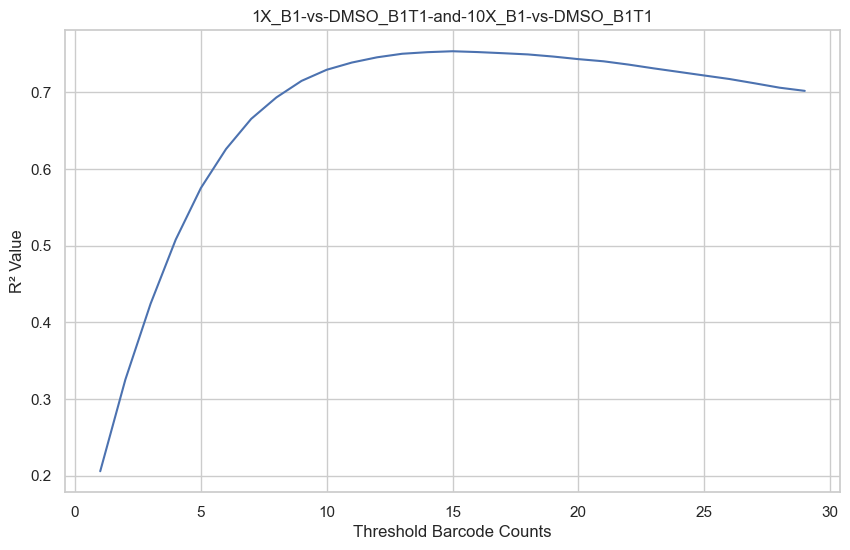

In [74]:
plot_r2_vs_threshold(func_score_comparisons_coverage, '1X_B1-vs-DMSO_B1T1-and-10X_B1-vs-DMSO_B1T1',30)

In [76]:
for key in func_score_comparisons_coverage:
    func_score_comparisons_coverage[key] = calculate_n_selections(func_score_comparisons_coverage[key], 5)

DMSO Barcode Count Frequency For 1X_B1-vs-DMSO_B1T1-and-5X_B1-vs-DMSO_B1T1


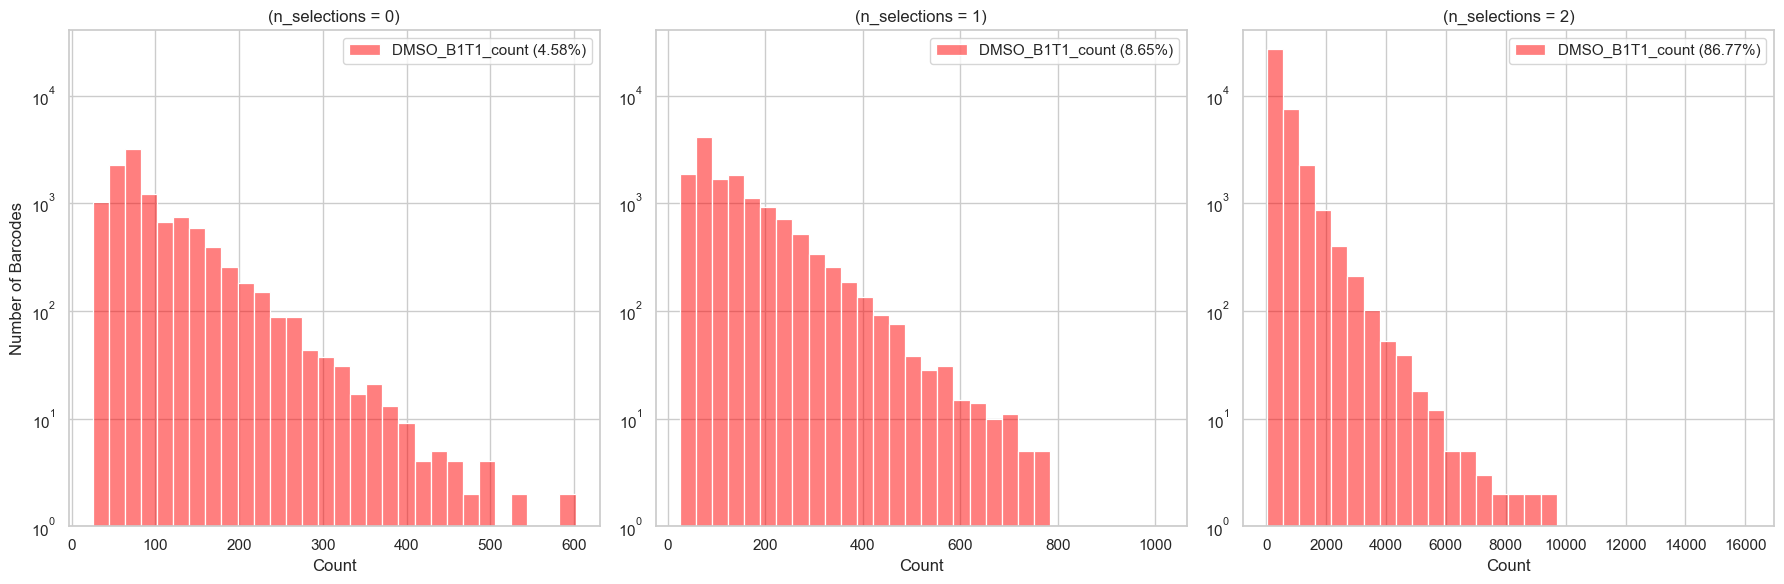

In [81]:
plot_count_histograms(func_score_comparisons_coverage, '1X_B1-vs-DMSO_B1T1-and-5X_B1-vs-DMSO_B1T1')

DMSO Barcode Count Frequency For 1X_B1-vs-DMSO_B1T1-and-10X_B1-vs-DMSO_B1T1


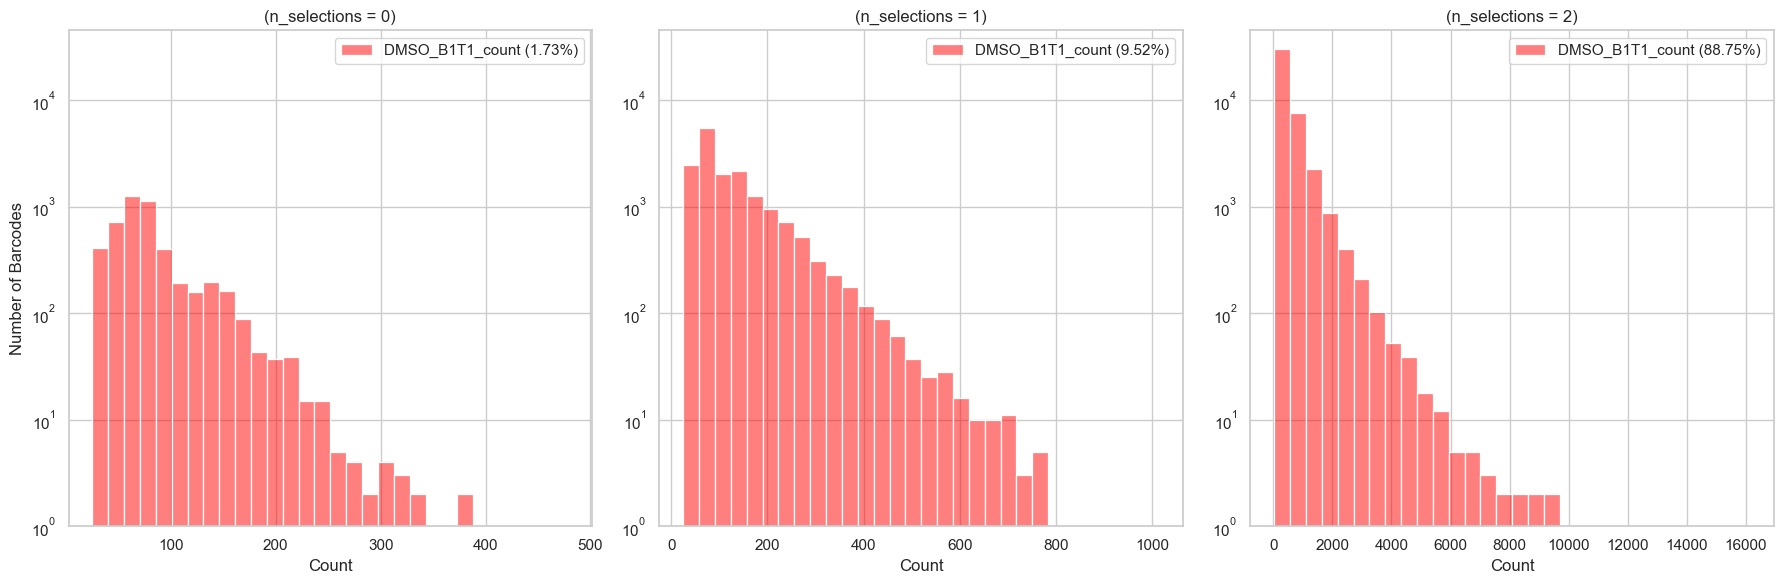

In [82]:
plot_count_histograms(func_score_comparisons_coverage, '1X_B1-vs-DMSO_B1T1-and-10X_B1-vs-DMSO_B1T1')

DMSO Barcode Count Frequency For 5X_B1-vs-DMSO_B1T1-and-10X_B1-vs-DMSO_B1T1


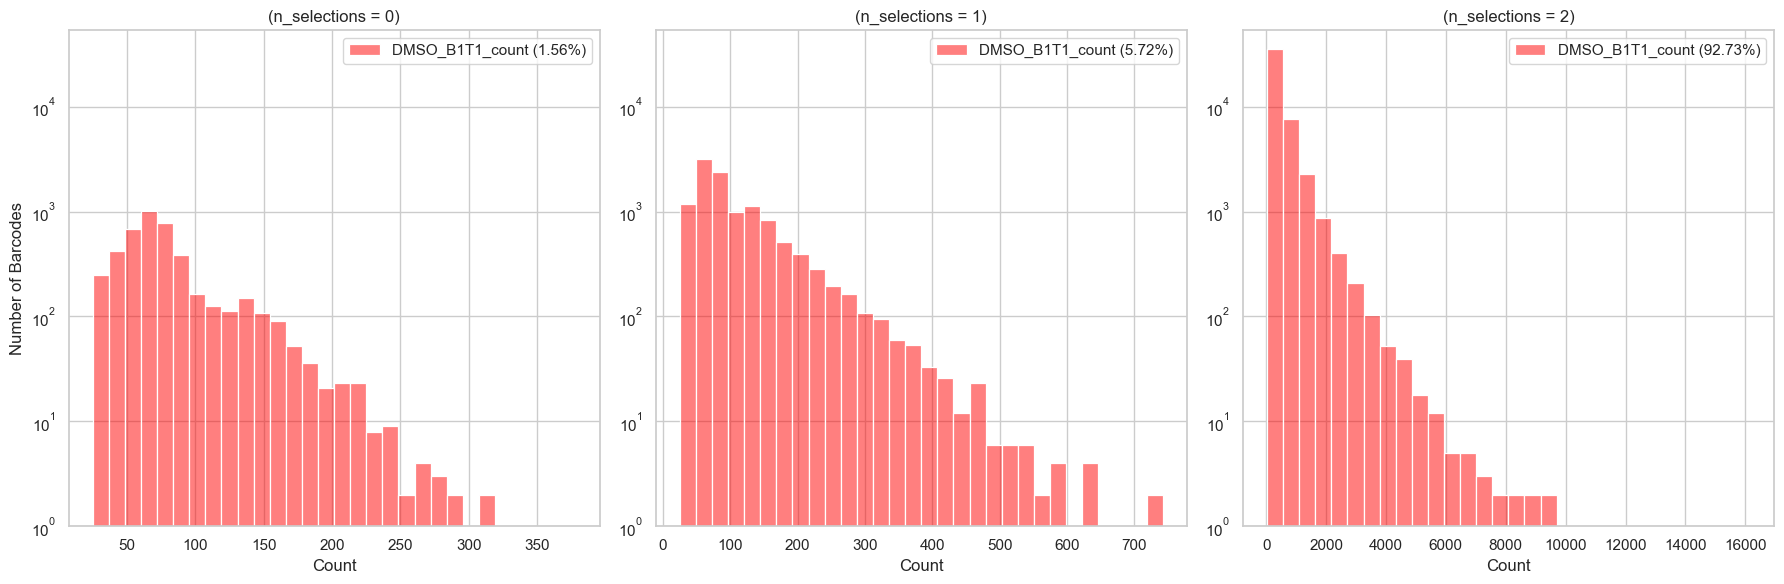

In [80]:
plot_count_histograms(func_score_comparisons_coverage, '5X_B1-vs-DMSO_B1T1-and-10X_B1-vs-DMSO_B1T1')

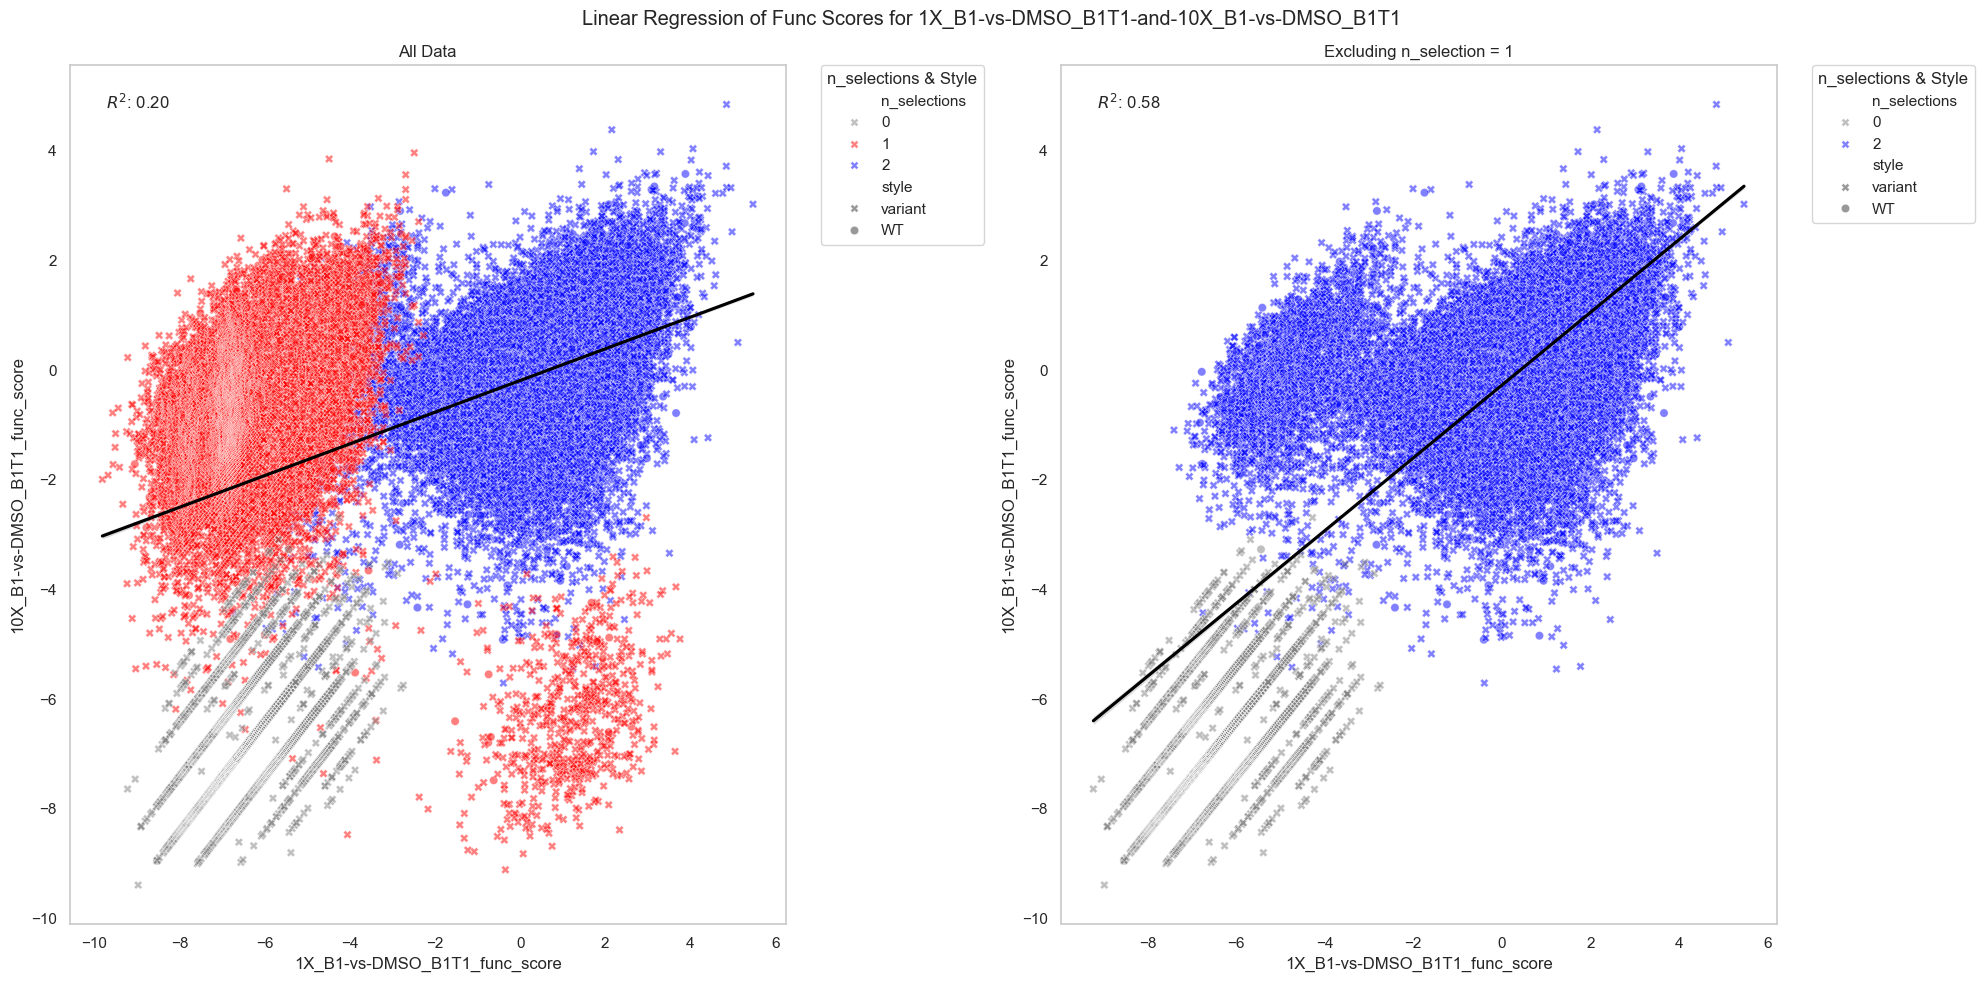

In [77]:
plot_func_scores(func_score_comparisons_coverage, '1X_B1-vs-DMSO_B1T1-and-10X_B1-vs-DMSO_B1T1')

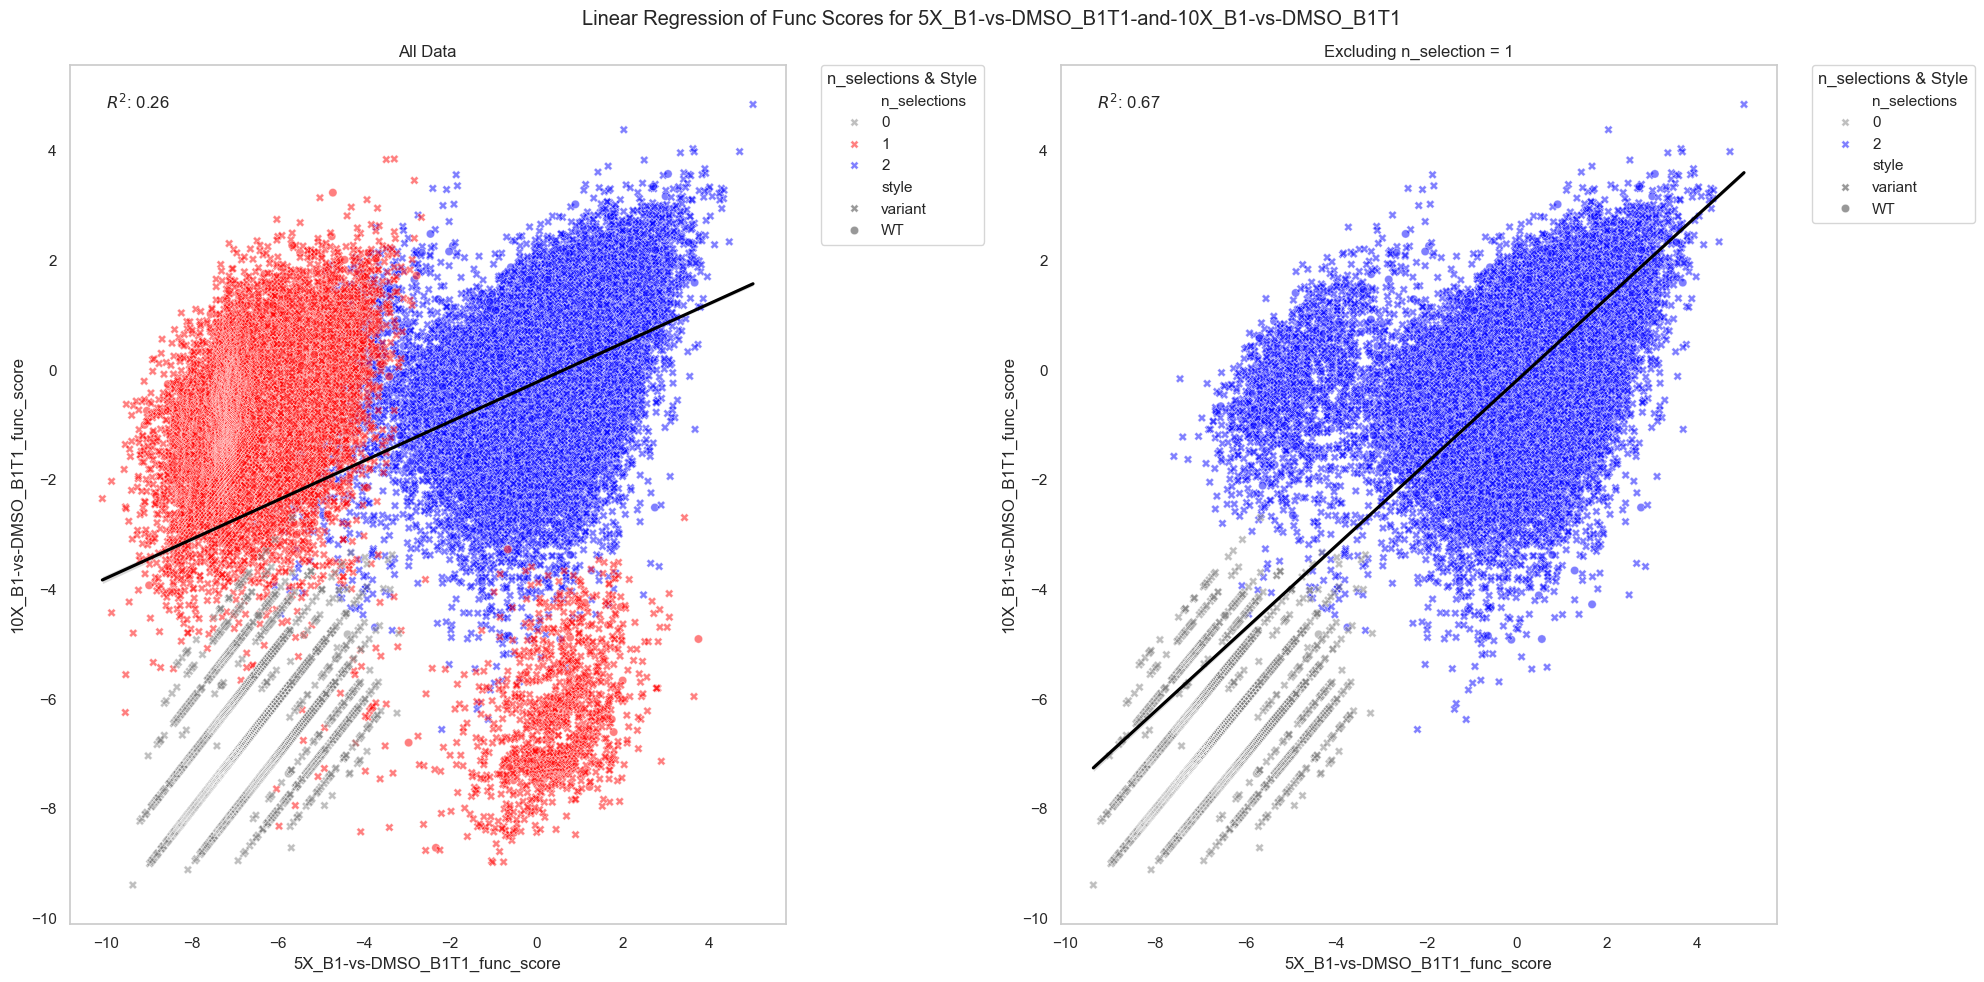

In [79]:
plot_func_scores(func_score_comparisons_coverage, '5X_B1-vs-DMSO_B1T1-and-10X_B1-vs-DMSO_B1T1')